In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
import tomli
from scipy.optimize import curve_fit

In [2]:
def read_experiment_file(filename):
    metadata = {}
    data = []
    
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    # Parse metadata
    data_start = None
    for i, line in enumerate(lines):
        if line.strip() == "":
            continue
        
        parts = line.split('\t')
        if len(parts) == 2 and not parts[0].replace('.', '', 1).isdigit():
            key, value = parts
            metadata[key.strip()] = value.strip()
        elif "Current / A" in parts[0]:
            data_start = i + 1
            break
    
    # Read numerical data
    if data_start is not None:
        for line in lines[data_start:]:
            values = line.split('\t')
            if len(values) == 3:
                try:
                    data.append([float(v) for v in values])
                except ValueError:
                    continue  # Skip malformed lines
    
    df = pd.DataFrame(data, columns=["Current (A)", "Voltage (uV)", "Time (s)"])
    
    return metadata, df

In [3]:
# filename = "data/Ic_Data.txt"  # Change this to your actual file path
# metadata, df = read_experiment_file(filename)

# print("Metadata:", metadata)
# print("Data:")
# print(df.head())

In [4]:
# # Convert dataframe columns to NumPy arrays
# current = df["Current (A)"].to_numpy()
# voltage = df["Voltage (uV)"].to_numpy()
# time = df["Time (s)"].to_numpy()

# print(current[:5])  # Print first 5 values as a check
# print(voltage[:5])
# print(time[:5])

In [5]:
def sigmoid(x):
     return np.where(x >= 0, 
                    1 / (1 + np.exp(-x)), 
                    np.exp(x) / (1 + np.exp(x))) 

In [6]:
def discontinous(x,a,b,c,d,n):
    y = x-b
    return a*x+c + d*sigmoid(y/1)*np.abs(y)**np.clip(n, -10, 10)

In [225]:
def plot_voltage(cur, volt, savefig,name,ax=None):
    print((5/3)*np.mean(cur),)
    p0 = [0.1,(5/3)*np.mean(cur), -3, 0.000, 7]
    if ax is not None:
       ax = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    popt, pcov = curve_fit(discontinous, cur, volt,p0=p0,bounds=([0.01, 20, -3, 0, 3],[1, 70, -1, 0.01, 7]))
    print(popt)
    #print(popt)
    plt.plot(cur,volt)
    plt.plot(cur, discontinous(cur,*popt), label="Fitted Curve", color="blue")
    #plt.plot(cur, discontinous(cur,*p0), label="Fitted Curve", color="blue")
    plt.xlabel("Current")
    plt.ylabel("Voltage")
    if savefig:
        plt.savefig(os.getcwd() + "/" + name)
    return ax

In [230]:
tesla_values = [0,0.025,0.05,0.1,0.2,0.3,0.4,0.5]
current_values = []
voltage_values  = []
for i, tesla in enumerate(tesla_values):
    metadata, df = read_experiment_file(f"data/Ic_data_{tesla:.3g}T.txt")
    current = df["Current (A)"].to_numpy()
    voltage = df["Voltage (uV)"].to_numpy()
    current_values.append(current)
    voltage_values.append(voltage)

for i, tesla in enumerate(tesla_values):
    plot_voltage(current_values[i],voltage_values[i],0,"plot_1")
#plot_voltage(current_values[0],voltage_values[0],0,"plot_1")



FileNotFoundError: [Errno 2] No such file or directory: 'data/Ic_Data_0T.txt'

66.62319916415915
[ 7.99104504e-02  6.04371915e+01 -2.36975807e+00  2.94354650e-05
  4.70037400e+00]
60.39825929126214
[ 9.27279394e-02  4.60024554e+01 -2.78249150e+00  2.65741033e-08
  6.40083636e+00]
49.73557102951039
[ 8.55085255e-02  3.71056326e+01 -2.99507990e+00  1.15720104e-06
  5.55354437e+00]
38.559024994054695
[ 7.06138725e-02  2.00000000e+01 -2.77227898e+00  2.82415894e-08
  6.44331218e+00]
32.48280476547482
[ 5.29551353e-02  2.16341788e+01 -1.89625572e+00  8.48157258e-05
  4.56835552e+00]
28.74659866098733
[ 1.06051619e-01  2.00000000e+01 -2.68484472e+00  5.53186305e-04
  4.21159227e+00]
25.41711523775216
[ 9.25077633e-02  2.00000000e+01 -2.26709849e+00  1.00000000e-02
  3.48872764e+00]


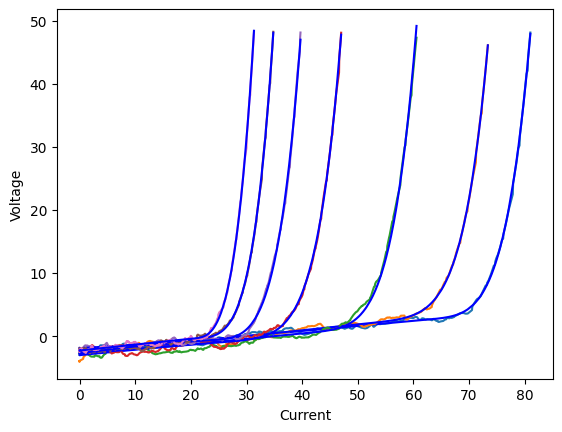

In [227]:
tesla_values = [0,0.025,0.05,0.1,0.2,0.3,0.4,0.5]
current_values = []
voltage_values  = []
for i, tesla in enumerate(tesla_values):
    metadata, df = read_experiment_file(f"data/Ic_data_45_{tesla:.3g}T.txt")
    current = df["Current (A)"].to_numpy()
    voltage = df["Voltage (uV)"].to_numpy()
    current_values.append(current)
    voltage_values.append(voltage)

for i, tesla in enumerate(tesla_values):
    plot_voltage(current_values[i],voltage_values[i],0,"plot_1")
#plot_voltage(current_values[0],voltage_values[0],0,"plot_1")


67.92739013940141
[ 8.01595255e-02  6.55650131e+01 -2.59115754e+00  6.82262227e-04
  3.91402330e+00]
66.21491537432037
[ 8.21501904e-02  5.35850924e+01 -2.28440738e+00  3.88960469e-09
  6.99998907e+00]
64.02154444876065
[ 8.30015408e-02  5.08548788e+01 -2.40173619e+00  4.29216987e-09
  6.99999997e+00]
58.74248863717129
[ 8.55626831e-02  4.67023240e+01 -2.24473458e+00  1.24210285e-07
  6.13751580e+00]
51.09440636085627
[ 7.21381573e-02  4.01423645e+01 -2.23480591e+00  1.22463272e-06
  5.65337194e+00]
44.93980148967552
[ 9.55971960e-02  4.15719050e+01 -2.09815232e+00  2.65943429e-03
  3.74190024e+00]
40.84173183875795
[ 6.15657076e-02  3.11602270e+01 -1.94475736e+00  6.55419686e-06
  5.41523969e+00]
36.6496720379437
[ 5.55140929e-02  2.51917449e+01 -1.30244646e+00  5.39286108e-07
  6.11410348e+00]


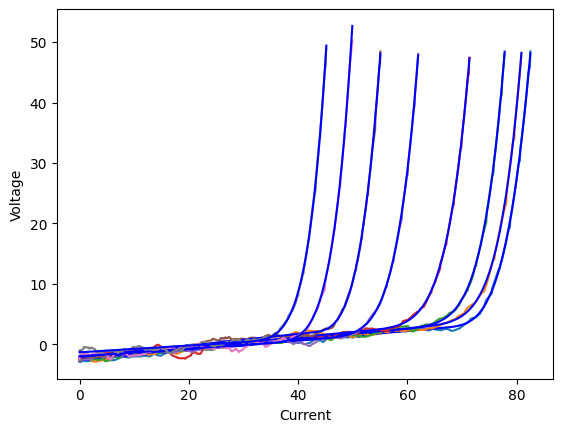

In [229]:
tesla_values = [0,0.025,0.05,0.1,0.2,0.3,0.4,0.5]
current_values = []
voltage_values  = []
for i, tesla in enumerate(tesla_values):
    metadata, df = read_experiment_file(f"data/Ic_data_90_{tesla:.3g}T.txt")
    current = df["Current (A)"].to_numpy()
    voltage = df["Voltage (uV)"].to_numpy()
    current_values.append(current)
    voltage_values.append(voltage)

for i, tesla in enumerate(tesla_values):
    plot_voltage(current_values[i],voltage_values[i],0,"plot_1")
#plot_voltage(current_values[0],voltage_values[0],0,"plot_1")
